### Initialize Software Environment

In [1]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import numpy as np
import folium
from folium import plugins
from IPython.display import display
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Define functions
-[Python Elasticsearch DSL](http://stackoverflow.com/questions/29380198/aggregate-a-field-in-elasticsearch-dsl-using-python)  
-[Python Elasticsearch DSL Library Documentation](http://elasticsearch-dsl.readthedocs.io/en/latest/search_dsl.html)  
-[Elasticsearch DSL Filter](http://stackoverflow.com/questions/28564303/how-do-i-create-an-or-filter-using-elasticsearch-dsl-py)  
-[Folium library example](https://blog.dominodatalab.com/creating-interactive-crime-maps-with-folium/)  
-[Folium Python Library](https://pypi.python.org/pypi/folium)  
-[Display Folium map in Jupyter notebook](https://github.com/python-visualization/folium/issues/90)  
-[Open Street Map copyright](http://www.openstreetmap.org/copyright)

In [2]:
def aggregate_term(clusterobj,
                   term,
                   businesscounty=None):
    """ Computes a term aggregation
    
    Args;
        clusterobj: Elasticsearch cluster handle
        
        term: String that stores a term
        
        businesscounty: (Optional) Refers to a specific county
    
    Returns:
        term_aggregation: List of tuples that stores a term
                          aggregation"""
    if businesscounty is None:
        searchobj = Search(using=clusterobj,
                           index="texasopendata",
                           doc_type="tdlr")
    else:
        searchobj =\
            Search(using=clusterobj,
                   index="texasopendata",
                   doc_type="tdlr").query('match',
                                          businesscounty=businesscounty)
    
    aggregation_name = 'by_' + term
    
    searchobj.aggs.bucket(aggregation_name,
                          'terms',
                          field=term,
                          size=0)

    resultsobj = searchobj.execute()

    term_aggregation = []

    for elem in resultsobj.aggregations[aggregation_name].buckets:
        term_aggregation.append((elem['doc_count'], elem['key']))
        
    return term_aggregation

def get_term_counts(term_aggregation):
    """ Returns a list of term counts
    
    Args:
        term_aggregation: List of tuples that stores a term aggregation
    
    Returns:
        term_count: List of term counts"""
    return[elem[0] for elem in term_aggregation]

def compute_cumulativecount_statistic(term_aggregation):
    """ Computes a cumulative count statistic that is analagous
    to a Cumulative Distribution Function (CDF)
    
    Args:
        term_aggregation: List of tuples that stores a term aggregation
    
    Returns:
        cumulativecount_statistic: Cumulative count statistic that is
                                   analagous to a CDF"""
    normalized_counts = get_term_counts(term_aggregation)

    total_counts = np.sum(normalized_counts)

    normalized_counts = normalized_counts / total_counts

    return np.cumsum(normalized_counts)

def eval_term_percentcontribution(term,
                                  term_aggregation,
                                  cumulativecount_statistic,
                                  threshold):
    """ Estimates the percent contribution of each unique term instance
    
    Args:
        term: String that refers to a specific term
        
        term_aggregation: List of tuples that stores a term aggregation
        
        cumulativecount_statistic: Cumulative count statistic that is
                                   analagous to a CDF
        
        threshold: Cumulative count statistic threshold"""
    threshold_idx = int(np.argwhere(bylicensetype_cdf >= threshold)[0])
    
    print("%d %s span %g%% of all %s" % (threshold_idx+1,
                                         term,
                                         100*threshold,
                                         term))
    print("")
    total_counts = np.sum(get_term_counts(term_aggregation))
    print("Total counts:%d" % (total_counts))
    print("")

    term_aggregation = term_aggregation[:threshold_idx+1]

    percent_contribution = [(np.round(100.0*elem[0] / float(total_counts), 1),
                            elem[1]) for elem in term_aggregation]

    for elem in percent_contribution:
        print("%s:  %g%% of total counts" % (elem[1], elem[0]))

def generate_licensetype_heatmap(clusterobj,
                                 licensetype,
                                 businesscounty):
    """ Generates a licensetype heatmap for a specific businesscounty
    
    Args:
        clusterobj: Elasticsearch cluster handle
        
        licensetype: String that refers to a specific license type

        businesscounty: String that refers to a specific businesscounty"""
    searchobj = Search(using=clusterobj,
                       index="texasopendata",
                       doc_type="tdlr"
                ).filter(
                    "term", businesscounty=businesscounty
                ).filter(
                    "term", licensetype=licensetype
                )

    mailingaddresslocation = []

    for elem in searchobj.scan():
        if elem.mailingaddresslocation['lat'] != -1 and\
           elem.mailingaddresslocation['lat'] != -1:
            mailingaddresslocation.append((elem.mailingaddresslocation['lat'],
                                           elem.mailingaddresslocation['lon']))

    center_latitude = np.mean([elem[0] for elem in mailingaddresslocation])
    center_longitude = np.mean([elem[1] for elem in mailingaddresslocation])

    map_osm = folium.Map(location=[center_latitude, center_longitude])
    map_osm.add_children(plugins.HeatMap(mailingaddresslocation,
                                         min_opacity=0.1))
    display(map_osm)
    
    map_osm.save(re.sub(' ', '', licensetype) + "_" + businesscounty + ".html")

### Initialize Elasticsearch cluster reference

In [3]:
clusterobj = Elasticsearch('localhost:9200')

### Compute statistics

In [4]:
term = 'licensetype'
threshold = 0.9

bylicensetype = aggregate_term(clusterobj, term)
    
bylicensetype_cdf = compute_cumulativecount_statistic(bylicensetype)

eval_term_percentcontribution(term,
                              bylicensetype,
                              bylicensetype_cdf,
                              threshold)

18 licensetype span 90% of all licensetype

Total counts:577746

Cosmetology Operator:  25.7% of total counts
Apprentice Electrician:  18.3% of total counts
Cosmetology Manicurist:  8.4% of total counts
Journeyman Electrician:  6.6% of total counts
A/C Technician:  4.6% of total counts
Cosmetology Esthetician:  4% of total counts
Cosmetology Beauty Salon:  4% of total counts
Master Electrician:  2.9% of total counts
A/C Contractor:  2.8% of total counts
Barber, Class A:  2.7% of total counts
Legal Service Contract Sales Rep:  1.9% of total counts
Electrical Contractor:  1.7% of total counts
Cos Mini Salon:  1.6% of total counts
Tow Truck Operator (Incident Management):  1.3% of total counts
Cosmetology Esthetician/Manicure Salon:  1.1% of total counts
Tow Truck Operator (Consent Tow):  1.1% of total counts
Cosmetologist:  1.1% of total counts
Cosmetology Operator Instructor:  1% of total counts


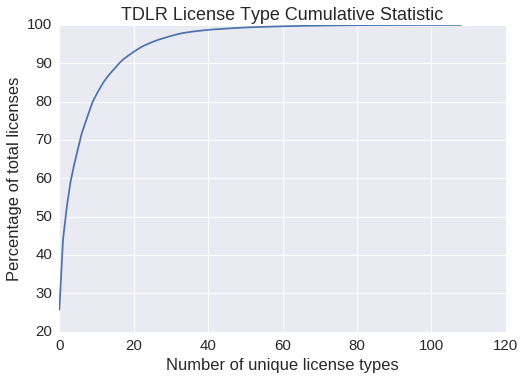

In [5]:
sns.set(font_scale=1.5)
plt.plot(100*bylicensetype_cdf)
plt.xlabel('Number of unique license types')
plt.ylabel('Percentage of total licenses')
plt.title('TDLR License Type Cumulative Statistic')
plt.savefig('licensetype.png')

In [6]:
term = 'businesscounty'
threshold = 0.9

bybusinesscounty = aggregate_term(clusterobj, term)
    
bybusinesscounty_cdf = compute_cumulativecount_statistic(bybusinesscounty)

eval_term_percentcontribution(term,
                              bybusinesscounty,
                              bybusinesscounty_cdf,
                              threshold)

18 businesscounty span 90% of all businesscounty

Total counts:551934

HARRIS:  19.8% of total counts
DALLAS:  10.2% of total counts
TARRANT:  7% of total counts
BEXAR:  5.9% of total counts
OUT OF STATE:  4.9% of total counts
TRAVIS:  3.9% of total counts
HIDALGO:  3% of total counts
COLLIN:  2.5% of total counts
DENTON:  2.2% of total counts
EL PASO:  2.2% of total counts
FORT BEND:  2.1% of total counts
MONTGOMERY:  1.8% of total counts
WILLIAMSON:  1.7% of total counts
BRAZORIA:  1.5% of total counts
GALVESTON:  1.2% of total counts
NUECES:  1.1% of total counts
CAMERON:  1% of total counts
JEFFERSON:  1% of total counts


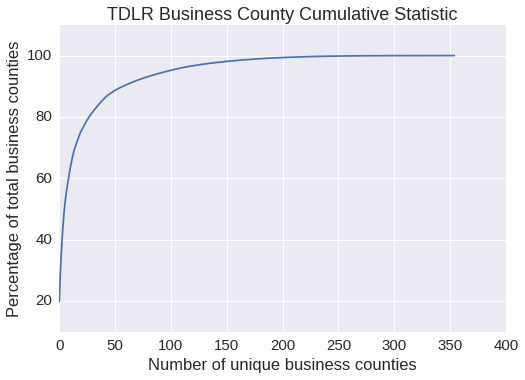

In [7]:
sns.set(font_scale=1.5)
plt.plot(100*bybusinesscounty_cdf)
plt.xlabel('Number of unique business counties')
plt.ylabel('Percentage of total business counties')
plt.title('TDLR Business County Cumulative Statistic')
plt.savefig('businesscounty.png')

In [8]:
term = 'licensetype'
businesscounty = 'HARRIS'
threshold = 0.9

bylicensetype = aggregate_term(clusterobj,
                               term,
                               businesscounty)
    
bylicensetype_cdf = compute_cumulativecount_statistic(bylicensetype)

eval_term_percentcontribution(term,
                              bylicensetype,
                              bylicensetype_cdf,
                              threshold)

14 licensetype span 90% of all licensetype

Total counts:109270

Cosmetology Operator:  24.7% of total counts
Apprentice Electrician:  23.6% of total counts
Cosmetology Manicurist:  11.3% of total counts
Journeyman Electrician:  5.8% of total counts
A/C Technician:  4.9% of total counts
Cosmetology Esthetician:  4.4% of total counts
Cosmetology Beauty Salon:  3.4% of total counts
Barber, Class A:  2.7% of total counts
A/C Contractor:  2% of total counts
Tow Truck Operator (Incident Management):  1.8% of total counts
Cosmetologist:  1.8% of total counts
Master Electrician:  1.6% of total counts
Cosmetology Esthetician/Manicure Salon:  1.5% of total counts
Cos Mini Salon:  1.3% of total counts


### Generate heatmaps

In [9]:
generate_licensetype_heatmap(clusterobj,
                             'Cosmetology Operator',
                             'HARRIS')

In [10]:
generate_licensetype_heatmap(clusterobj,
                             'Apprentice Electrician',
                             'HARRIS')